<a href="https://colab.research.google.com/github/KarmenFabel/BirdClassification/blob/main/POEModelCreationClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/hadeerismail/100bird-types-classification-efficientnet-acc-99

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# training data

In [ ]:
# Define the directory containing the training data
traind = '/content/drive/MyDrive/Birds/train'

# Initialize empty lists to store file paths and labels
filepaths = []
labels = []

# List all subdirectories (folds) in the training directory
folds = os.listdir(traind)

# Iterate through each fold
for fold in folds:
    # Construct the full path to the fold
    foldpath = os.path.join(traind, fold)

    # List all files in the current fold
    filelist = os.listdir(foldpath)

    # Iterate through each file in the fold
    for file in filelist:
        # Construct the full file path
        fpath = os.path.join(foldpath, file)

        # Append the file path to the list
        filepaths.append(fpath)

        # Append the fold (label) to the labels list
        labels.append(fold)

# Concatenate the data paths with labels into a single dataframe
FileSeries = pd.Series(filepaths, name='filepaths')
LabelSeries = pd.Series(labels, name='labels')
train_df = pd.concat([FileSeries, LabelSeries], axis=1)

# Print the first few rows of the dataframe
print(train_df.head())


                                           filepaths           labels
0  /content/drive/MyDrive/Birds/train/ABBOTTS BAB...  ABBOTTS BABBLER
1  /content/drive/MyDrive/Birds/train/ABBOTTS BAB...  ABBOTTS BABBLER
2  /content/drive/MyDrive/Birds/train/ABBOTTS BAB...  ABBOTTS BABBLER
3  /content/drive/MyDrive/Birds/train/ABBOTTS BAB...  ABBOTTS BABBLER
4  /content/drive/MyDrive/Birds/train/ABBOTTS BAB...  ABBOTTS BABBLER


# Validation data

In [ ]:
# Define the directory containing the validation data
validationd = '/content/drive/MyDrive/Birds/valid'

# Initialize empty lists to store file paths and labels
filepaths = []
labels = []

folds = os.listdir(validationd)
for fold in folds:
    foldpath = os.path.join(validationd, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create Pandas Series for file paths and labels
FileSeries = pd.Series(filepaths, name= 'filepaths')  # Create a Series for file paths
LabelSeries = pd.Series(labels, name='labels')       # Create a Series for labels

# Concatenate the file paths and labels into a DataFrame
valid_df = pd.concat([FileSeries, LabelSeries], axis= 1)

# Print the first few rows of the DataFrame to inspect the data
print(valid_df.head())


                                           filepaths           labels
0  /content/drive/MyDrive/Birds/valid/ABBOTTS BAB...  ABBOTTS BABBLER
1  /content/drive/MyDrive/Birds/valid/ABBOTTS BAB...  ABBOTTS BABBLER
2  /content/drive/MyDrive/Birds/valid/ABBOTTS BAB...  ABBOTTS BABBLER
3  /content/drive/MyDrive/Birds/valid/ABBOTTS BAB...  ABBOTTS BABBLER
4  /content/drive/MyDrive/Birds/valid/ABBOTTS BAB...  ABBOTTS BABBLER


# Test data

In [ ]:
# Generate  test data paths with labels
testd = '/content/drive/MyDrive/Birds/test'
filepaths = []
labels = []

folds = os.listdir(testd)
for fold in folds:
    foldpath = os.path.join(testd, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)


FileSeries = pd.Series(filepaths, name= 'filepaths')
LabelSeries = pd.Series(labels, name='labels')
test_df = pd.concat([FileSeries, LabelSeries], axis= 1)
print(test_df.head())

                                           filepaths           labels
0  /content/drive/MyDrive/Birds/test/ABBOTTS BABB...  ABBOTTS BABBLER
1  /content/drive/MyDrive/Birds/test/ABBOTTS BABB...  ABBOTTS BABBLER
2  /content/drive/MyDrive/Birds/test/ABBOTTS BABB...  ABBOTTS BABBLER
3  /content/drive/MyDrive/Birds/test/ABBOTTS BABB...  ABBOTTS BABBLER
4  /content/drive/MyDrive/Birds/test/ABBOTTS BABB...  ABBOTTS BABBLER


In [ ]:
# Set the batch size and image dimensions
batch_size = 32
img_size = (224, 224) # Target image size
channels = 3 # Number of color channels (RGB)
img_shape = (img_size[0], img_size[1], channels) # Image shape for model input

# Initialize image data generators for preprocessing
tr_gen = ImageDataGenerator() # Data generator for training
ts_gen = ImageDataGenerator() # Data generator for testing and validation

# Create a training data generator
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical', # One-hot encode labels
    color_mode='rgb', # Use RGB color mode
    shuffle=True, # Shuffle data for each epoch
    batch_size=batch_size # Number of images per batch
)

# Create a validation data generator
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True, # Shuffle data for each epoch
    batch_size=batch_size
)

# Create a testing data generator
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False, # No need to shuffle test data
    batch_size=batch_size
)


Found 84635 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.


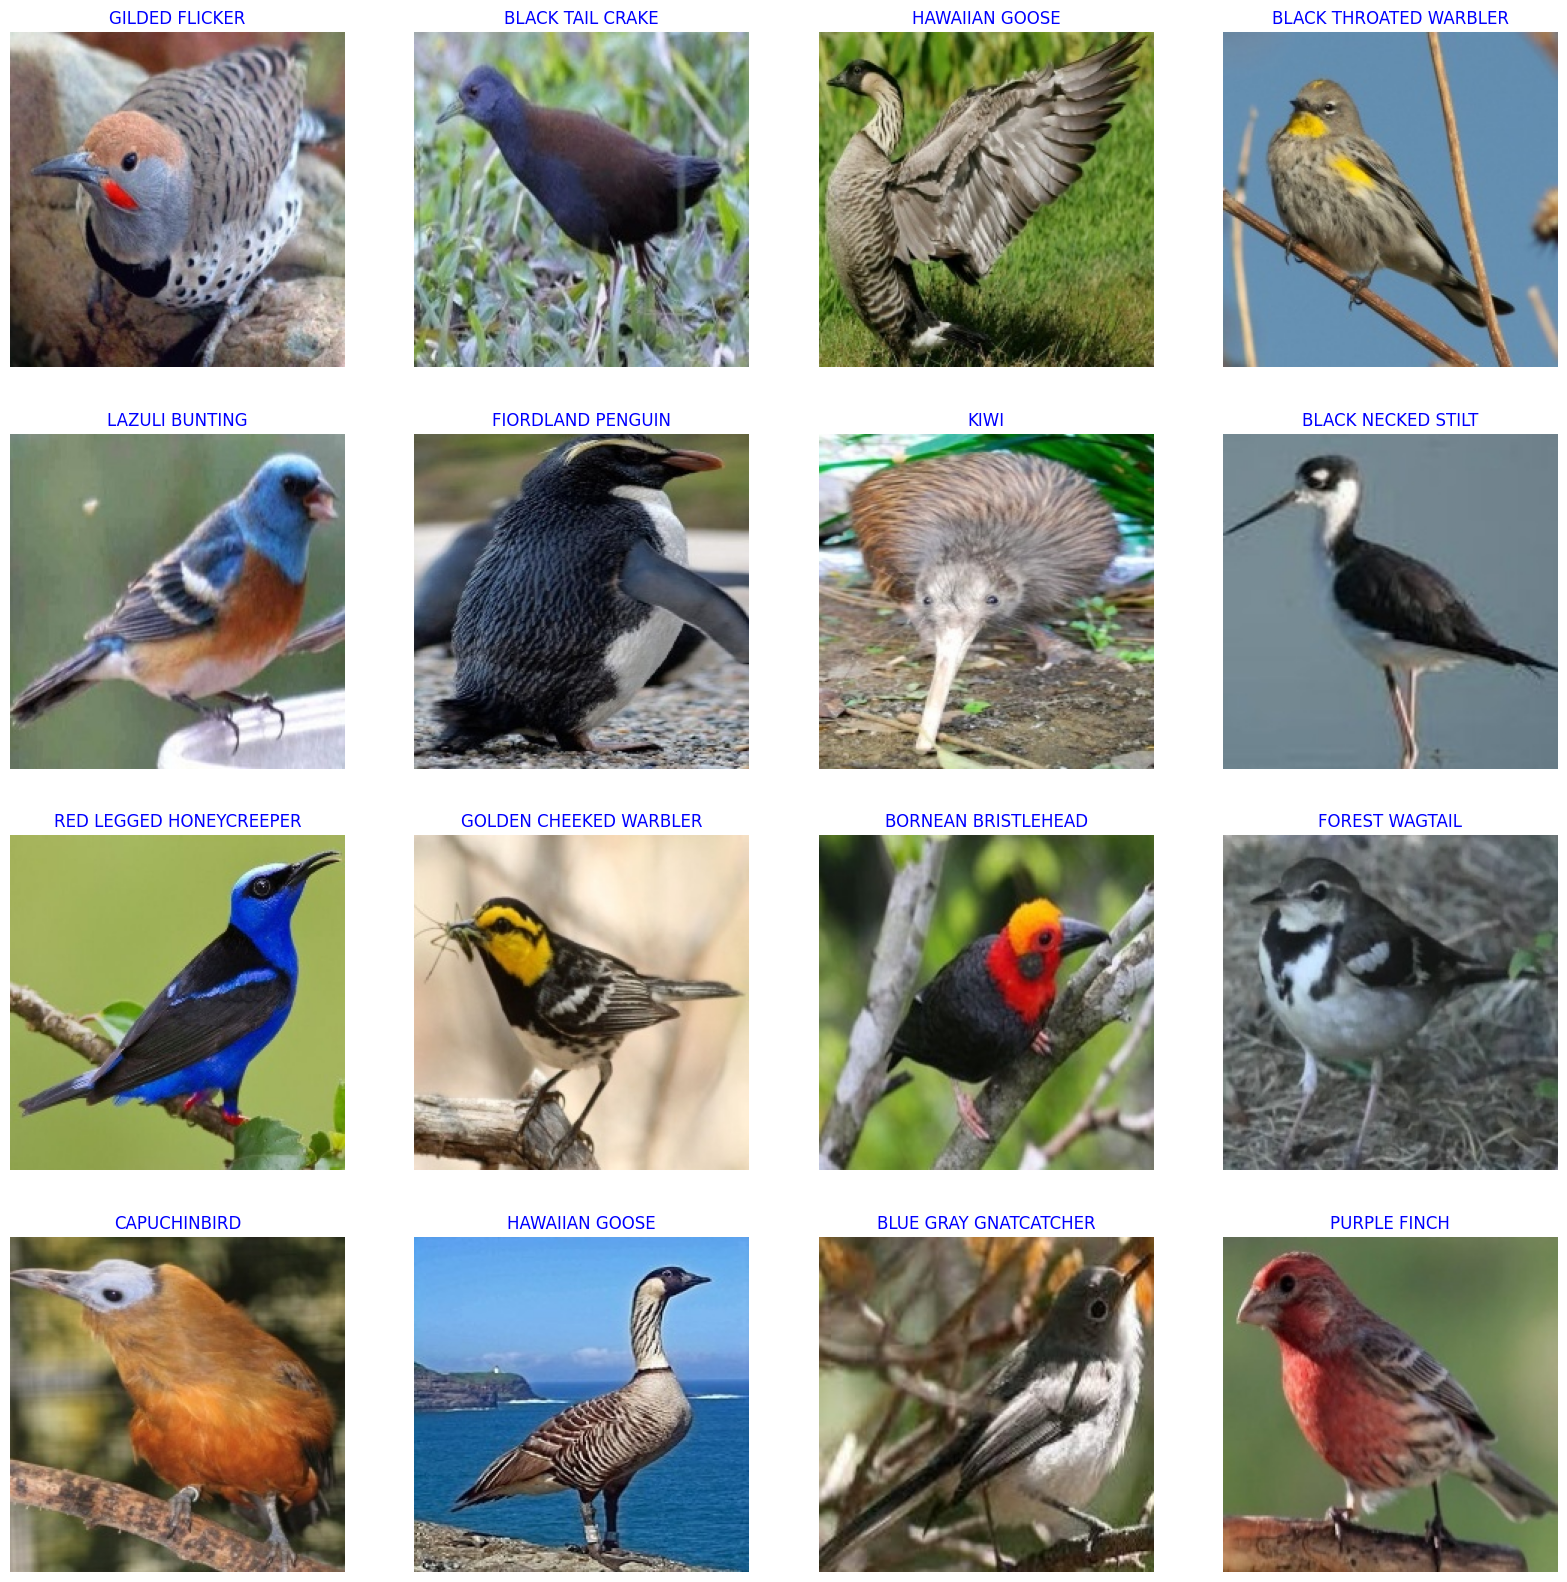

In [ ]:
# Retrieve the mapping of class names to their indices
diction = train_gen.class_indices

# Create a list of class names from the dictionary keys
classes = list(diction.keys())

# Retrieve a batch of images and their corresponding labels
images, labels = next(train_gen)

# Set up the figure for displaying images
plt.figure(figsize=(20, 20))

# Loop to display the first 16 images in the batch
for i in range(16):
    plt.subplot(4, 4, i + 1)  # Position each image in a 4x4 grid
    image = images[i] / 255   # Scale image pixel values for visualization
    plt.imshow(image)         # Display the image
    index = np.argmax(labels[i])  # Determine the index of the most likely class
    class_name = classes[index]   # Retrieve the class name using the index
    plt.title(class_name, color='blue', fontsize=12)  # Display the class name as the title
    plt.axis('off')  # Hide the axis for a cleaner look
plt.show()  # Display the plot with all images


In [ ]:
def create_image_classification_model(train_gen):
    # Define image size and channels
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)

    # Determine the number of unique classes
    class_count = len(list(train_gen.class_indices.keys()))

    # Initialize EfficientNetB0 as the base model with pre-trained weights
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape,
        pooling='max'
    )

    # Create the full classification model
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006),
              activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation='softmax')
    ])

    # Compile the model with optimizer, loss function, and metrics
    model.compile(
        Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Display the summary of the created model
model = create_image_classification_model(train_gen)
model.summary()


16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 525)               134925    
                                                         

In [ ]:
# Create the image classification model
model = create_image_classification_model(train_gen)

# Set batch size and number of epochs
batch_size = 32
epochs = 10

# Train the model
history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False)


Epoch 1/10
2645/2645 [==============================] - 749s 269ms/step - loss: 5.1032 - accuracy: 0.4976 - val_loss: 2.0767 - val_accuracy: 0.9109
Epoch 2/10
2645/2645 [==============================] - 709s 268ms/step - loss: 2.1303 - accuracy: 0.8566 - val_loss: 1.4390 - val_accuracy: 0.9421
Epoch 3/10
2645/2645 [==============================] - 709s 268ms/step - loss: 1.5293 - accuracy: 0.9168 - val_loss: 1.1504 - val_accuracy: 0.9581
Epoch 4/10
2645/2645 [==============================] - 711s 269ms/step - loss: 1.2234 - accuracy: 0.9427 - val_loss: 0.9714 - val_accuracy: 0.9646
Epoch 5/10
2645/2645 [==============================] - 711s 269ms/step - loss: 1.0233 - accuracy: 0.9578 - val_loss: 0.8562 - val_accuracy: 0.9707
Epoch 6/10
2645/2645 [==============================] - 710s 268ms/step - loss: 0.8813 - accuracy: 0.9676 - val_loss: 0.7608 - val_accuracy: 0.9722
Epoch 7/10
2645/2645 [==============================] - 710s 269ms/step - loss: 0.7769 - accuracy: 0.9747 - val_

In [ ]:
model.save('/content/drive/MyDrive/Birds/ImageModel.h5')


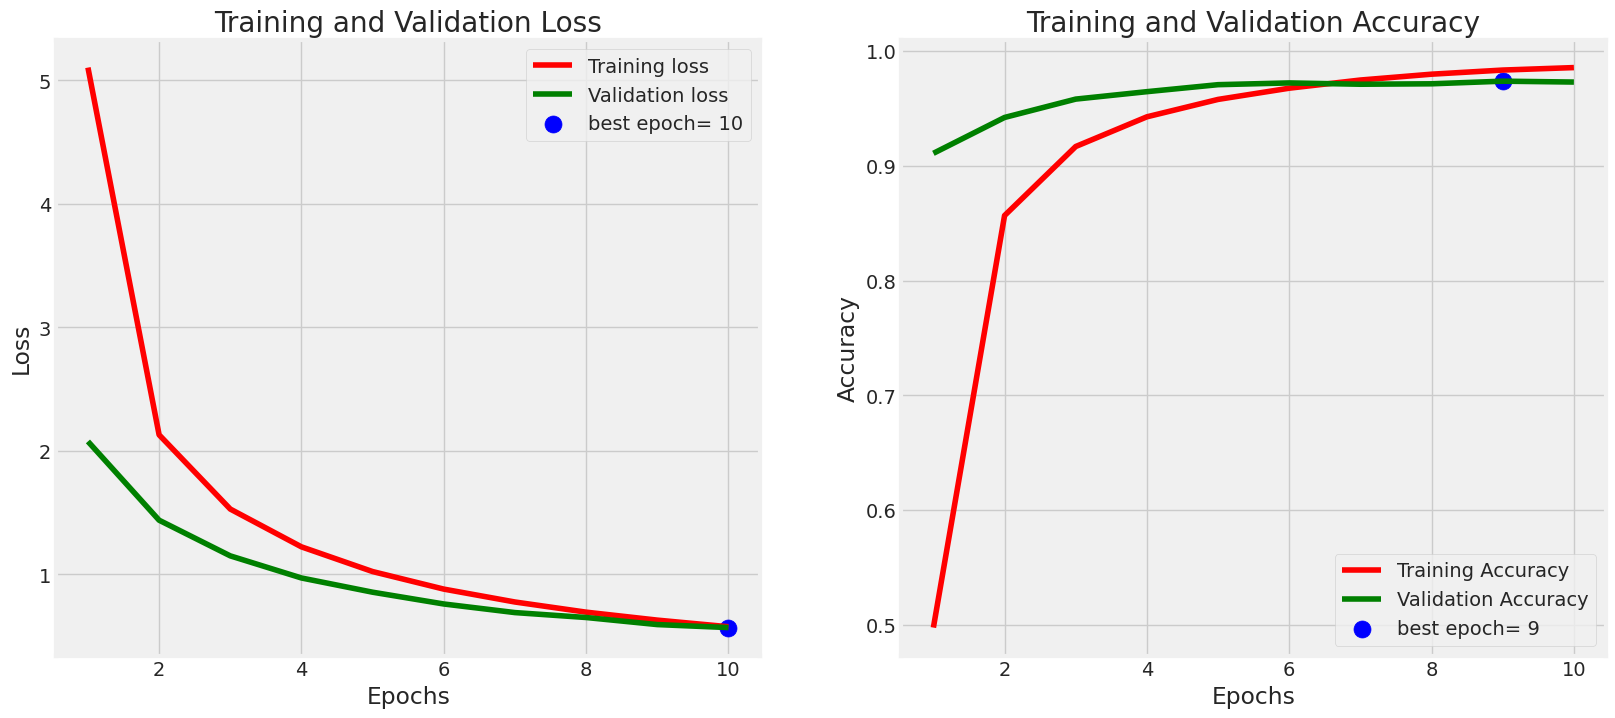

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

35/35 [==============================] - 2s 67ms/step - loss: 0.5211 - accuracy: 0.9875
Train Loss:  0.4746495485305786
Train Accuracy:  1.0
--------------------
Validation Loss:  0.5681324601173401
Validation Accuracy:  0.9758928418159485
--------------------
Test Loss:  0.5210984945297241
Test Accuracy:  0.987500011920929


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

KeyboardInterrupt: ignored

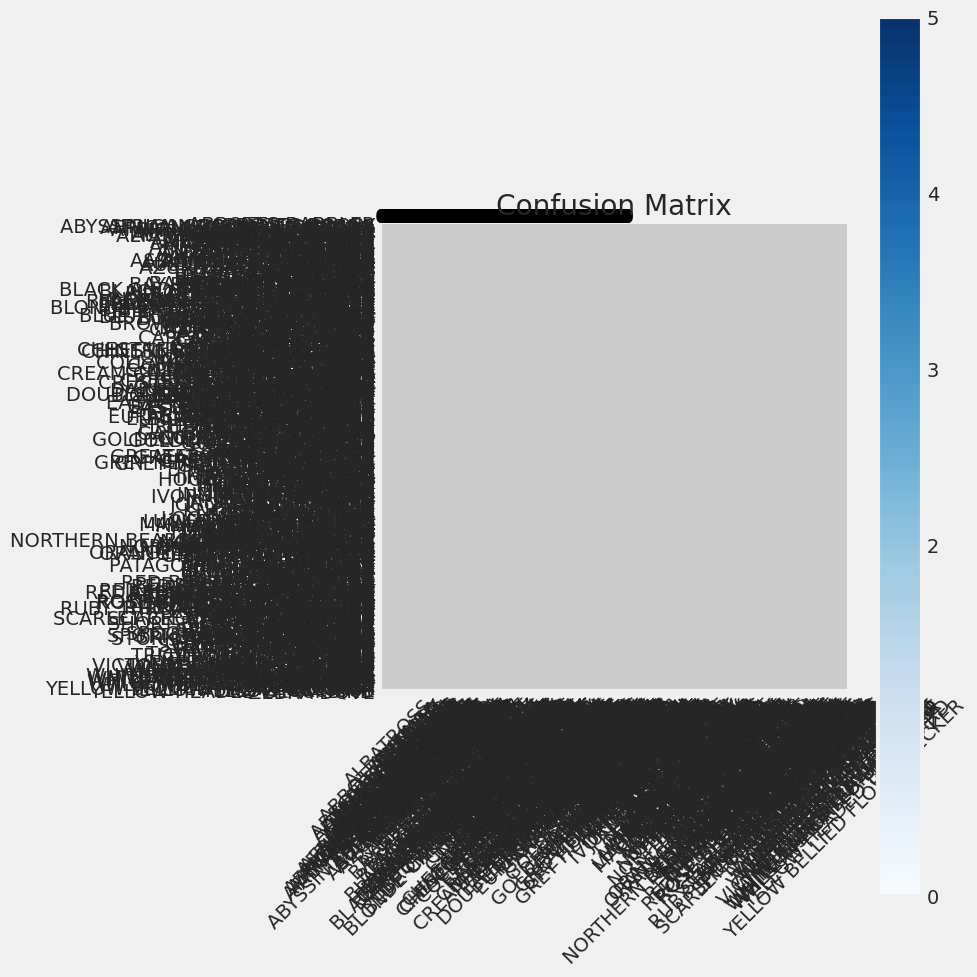

In [ ]:
diction = test_gen.class_indices
classes = list(diction.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Birds/ImageModel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      0.80      0.89         5
                ABBOTTS BOOBY       1.00      1.00      1.00         5
   ABYSSINIAN GROUND HORNBILL       1.00      0.80      0.89         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
          AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                    ALBATROSS       1.00      1.00      1.00         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
                ALPINE CHOUGH       1.00      1.00      1.00         5
     

In [ ]:
#Save the model
model.save('/content/drive/MyDrive/Birds/model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Birds/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
# Define the file path to the image
image_path = '/content/drive/MyDrive/Birds/test/ALPINE CHOUGH/4.jpg'

# Open the image using the Python Imaging Library (PIL)
image = Image.open(image_path)

# Preprocess the image by resizing it to the required dimensions
img = image.resize((224, 224))

# Convert the image to a NumPy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Expand the dimensions to match the model's input shape
img_array = tf.expand_dims(img_array, 0)

# Make predictions using the loaded model
predictions = loaded_model.predict(img_array)

# Get the class labels for reference
class_labels = classes

# Calculate the softmax scores for the predictions
score = tf.nn.softmax(predictions[0])

# Print the predicted class label based on the highest score
print(f"{class_labels[tf.argmax(score)]}")


1/1 [==============================] - 1s 1s/step
ALPINE CHOUGH
